In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pickle
import matplotlib.ticker as mtick
import math
from itertools import combinations
import random
from sklearn.linear_model import LinearRegression

In [2]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.set_palette("Dark2")

In [3]:
seed = 42

# load data

In [4]:
colour_list = pd.read_csv('../../data/colour_list.txt',header=None)[0].tolist()

In [5]:
protein_ruv = pd.read_csv(
    "../../data/protein/E0022_P06_Protein_Matrix_ProNorM_no_control_update.txt",
    sep='\t').set_index('Cell_line')

meta = pd.read_csv('../../data/E0022_P06_final_sample_map_no_control.txt',
                   sep='\t').set_index('Cell_line')

In [6]:
cell_lines_no_blood = meta[meta['Tissue_type']!='Haematopoietic and Lymphoid'].index.values

In [7]:
tissue_type_map = meta[['Tissue_type']].to_dict()['Tissue_type']
cancer_type_map = meta[['Cancer_type']].to_dict()['Cancer_type']
batch_map = meta[['Batch']].to_dict()['Batch']
instrument_map = meta[['Instrument']].to_dict()['Instrument']


In [8]:
cancer_colours = dict(
    zip(meta['Cancer_type'].unique(),
        colour_list[:meta['Cancer_type'].unique().size]))

tissue_colours = dict(
    zip(meta['Tissue_type'].unique(),
        colour_list[:meta['Tissue_type'].unique().size]))

instrument_colours={
    'M01':'#66c2a5', 
    'M02':'#fc8d62', 
    'M03':'#8da0cb', 
    'M04':'#e78ac3', 
    'M05':'#a6d854', 
    'M06':'#ffd92f'
}

batch_colours={
    'P01':'#7fc97f', 
    'P02':'#beaed4', 
    'P03':'#fdc086', 
    'P04':'#386cb0', 
    'P05':'#f0027f', 
    'P06':'#bf5b17'
}

In [9]:
meta = meta.reset_index()

In [10]:
meta_cell_lines = meta.drop_duplicates('Cell_line')

In [11]:
drug = pd.read_csv("../../data/drug/drug_info.csv")

In [12]:
drug_colours = dict(
    zip(drug['target_pathway'].unique(),
        colour_list[:drug['target_pathway'].unique().size]))

In [13]:
name_map = pd.read_csv("../../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

protein2rna_map = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))
rna2protein_map = {v: k for k, v in protein2rna_map.items()}

In [14]:
broad = pd.read_csv("../../data/ccle/ccle_proteins_sanger_name.csv").set_index("Cell_line")

# protein correlation

In [19]:
overlap_lines = list(set(protein_ruv.index.values).intersection(broad.index.values))

In [21]:
protein_ruv_common = protein_ruv[protein_ruv.index.isin(overlap_lines)].sort_values(by='Cell_line')

In [23]:
broad_common = broad[broad.index.isin(overlap_lines)].sort_values(by='Cell_line')

In [92]:
def scatter_plot(protein, protein_ruv_common, broad_common, tissues=[]):
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    tmp_df = pd.DataFrame({
        'Cell_line': protein_ruv_common.index.values,
        f'{protein}_sanger': protein_ruv_common[protein].values,
        f'{protein}_broad': broad_common[protein].values
    })
    tmp_df['tissue'] = tmp_df['Cell_line'].map(tissue_type_map)
    tmp_df = tmp_df.dropna()
    if len(tissues) == 0:
        tissues = tmp_df['tissue'].unique()
    tmp_df_tissue = tmp_df[tmp_df['tissue'].isin(tissues)].reset_index(drop=False)

    # tissues
    sns.scatterplot(x=f'{protein}_sanger',
                    y=f'{protein}_broad',
                    data=tmp_df_tissue,
                    hue='tissue',
                    hue_order=sorted(tmp_df_tissue['tissue'].unique()),
                    palette=tissue_colours,
                    edgecolor='black',
                    linewidth=0.7,
                    ax=ax[0],legend=None)
    r, pval = pearsonr(tmp_df_tissue[f'{protein}_sanger'],
                       tmp_df_tissue[f'{protein}_broad'])
    ax[0].text(0.05,
               0.05,
               f"$R={r:.4f}$ $p=${pval:.1e}",
               ha='left',
               va='center',
               transform=ax[0].transAxes,
               fontsize=14)

    # all
    sns.scatterplot(x=f'{protein}_sanger',
                    y=f'{protein}_broad',
                    data=tmp_df,
                    hue='tissue',
                    hue_order=sorted(tmp_df['tissue'].unique()),
                    palette=tissue_colours,
                    edgecolor='black',
                    linewidth=0.7,
                    ax=ax[1])
    r, pval = pearsonr(tmp_df[f'{protein}_sanger'], tmp_df[f'{protein}_broad'])
    ax[1].text(0.05,
               0.05,
               f"$R={r:.4f}$ $p=${pval:.1e}",
               ha='left',
               va='center',
               transform=ax[1].transAxes,
               fontsize=14)
    plt.legend(bbox_to_anchor=(1.02, 1),
               loc=2,
               borderaxespad=0.,
               prop={'size': 10})
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.4)

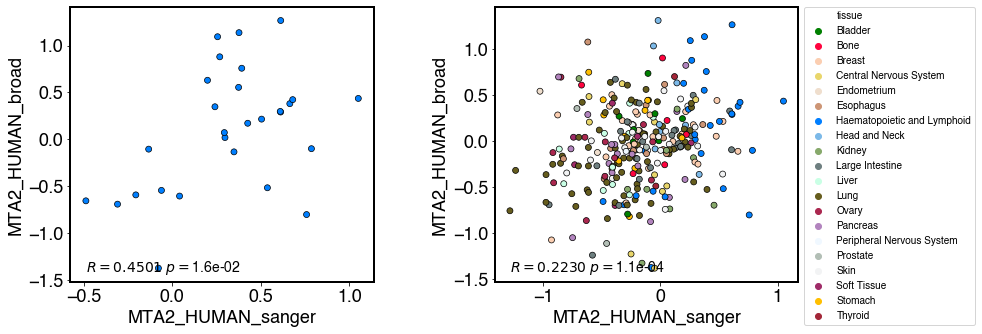

In [89]:
scatter_plot("MTA2_HUMAN",protein_ruv_common, broad_common,tissues=['Haematopoietic and Lymphoid'])

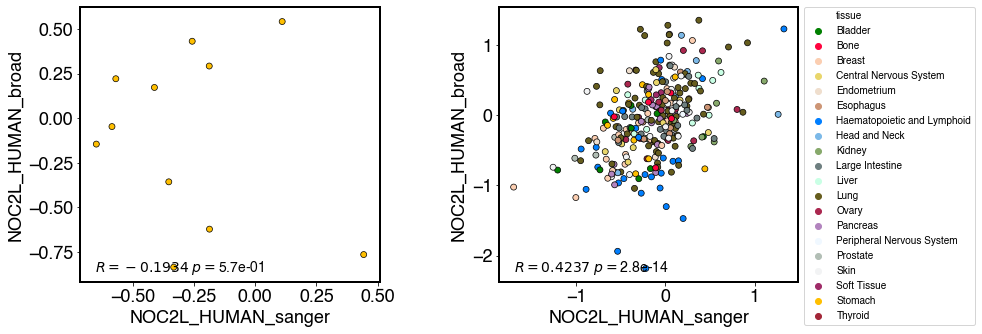

In [90]:
scatter_plot("NOC2L_HUMAN",protein_ruv_common, broad_common,tissues=['Stomach'])

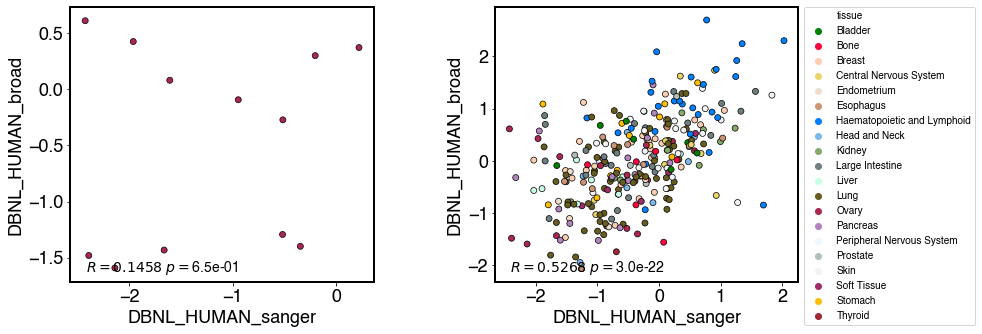

In [87]:
scatter_plot("DBNL_HUMAN",protein_ruv_common, broad_common,tissues=['Ovary'])

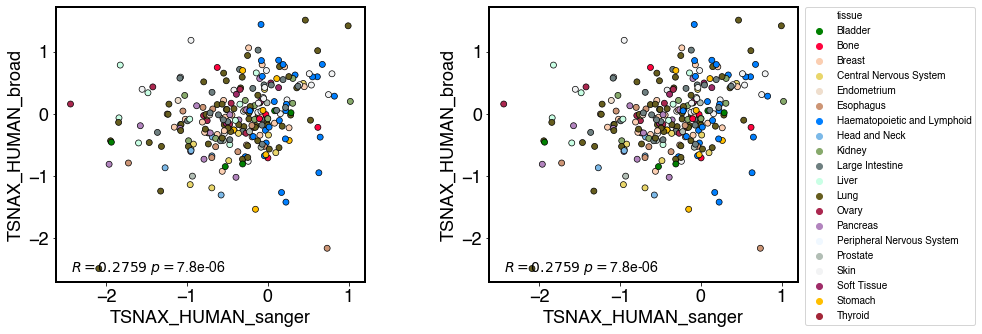

In [96]:
scatter_plot("TSNAX_HUMAN",protein_ruv_common, broad_common)